## Load Packages

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

## 1) Data Preperation 

### 1.1) Extract the XML files using the code provided by Prof. Shariyar

In [2]:
"""

@author: Shariyar

"""
import xml.etree.ElementTree

def updateContent(child: xml.etree.ElementTree, content:str):
    if (child.text is not None):
        content=content+child.text+" "
    if (child.tail is not None):
        content=content+child.tail+ " "
    return content
            
    
# Function to parse regulations only
def parseRegulation(root: xml.etree.ElementTree):
    '''
      Parses regulation based xml file
      :param root: xml node of type xml.etree.ElementTree
      :returns dictionary of keys and values
    '''
    xRefXternal=list()
    content=""
    modifiedYear="NA"
    regYear="NA"
    consolidationYear="NA"
    #dt=""
    #modFlag=False
    xmlDict=dict()
    
    
    for child in root.iter():
        #print (child.tag,child.text,child.tail)
        if child.tag=="XRefExternal":
            txt=""
            if child.text is None:
                if child[0].tail is not None:
                    txt=child[0].tail
                else:
                     txt=child[0].text
            else:
                txt=child.text
            xRefXternal.append(txt)
            content=updateContent(child,content)
            #content+=txt+" "
       # get modifed date 
        elif ("ModifiedDate" in child.tag):
         
            dateTag=child[0]
            #print(date[1].text)
            modifiedYear=dateTag[0].text
        elif (child.tag=="RegistrationDate"):
            dateTag=child[0]
            #print(date[1].text)
            regYear=dateTag[0].text
        elif (child.tag=="ConsolidationDate"):
            dateTag=child[0]
            #print(date[1].text)
            consolidationYear=dateTag[0].text 
        elif (child.tag=="InstrumentNumber"):
            xmlDict["instrumentNumber"]=child.text
        elif (child.tag=="ShortTitle"):
            xmlDict["shorttitle"]=child.text
        elif (child.tag=="RegulationMaker"):
            xmlDict["regulationmaker"]=child.text
        elif (child.tag=="LongTitle"):
            xmlDict["longtitle"]=child.text 
            content+=child.text+". "
        elif (child.tag=="TitleText"):
            if child.text is None:
                if len(child)>0  and child[0].text is not None:
                    content+=child[0].text+". "
            else:
                content+=child.text+". "
       
            
        elif child.tag=="MM" or child.tag=="DD" or child.tag=="YYYY"  or child.tag=="Label":
            continue;
        elif child.tag=="Repealed":
            #print (child.text)
            return None # igonre reglations with repeal keywords
            
        else:
            content=updateContent(child,content)
            #print(child.tag,child.text)
            '''if (child.text is not None):
            
                content=content+child.text+" "
            if (child.tail is not None):
                content=content+child.tail+ " "'''
                
           
    xmlDict["modifiedyear"]=modifiedYear
    xmlDict["registrationyear"]=regYear
    xmlDict["consolidationyear"]=consolidationYear
    xmlDict["xrefxternal"]=xRefXternal
    xmlDict["content"]=content
    
    
    return (xmlDict)

#PARSE REGULATIONS
import os
import xml.etree.ElementTree as ET

#define the path for regulations data
directory="/Users/eishapatel/Desktop/DS - 8008/DS 8008 - project/regulations"
count=0
n=0
#create an empty list to store parsed regulations. Where each element is a dictionary for a file
Reg_datadict_list=[]

for filename in os.listdir(directory):
    # use all xml files, starting from SOR-200* and does not include SI
    #P.S. "SOR-2002-10" gets only 5 names for testing
    # Add for reducing the data: and (filename.startswith("SOR-2002-1"))
    if filename.endswith(".xml") and (not filename.startswith("SI-")):
        #print (filename)
        path=os.path.join(directory, filename)
        tree=ET.parse(path)
        #call the parsing function
        d=parseRegulation(tree.getroot())
        # if it's not a Repealed or Revoked regulation, then append the list
        if(d != None):
            Reg_datadict_list.append(d)

print("The columns for Regulation dictionary: ----->",Reg_datadict_list[1].keys())
print("number of files parsed ", len(Reg_datadict_list))
#print("Values for row 0 ********",Reg_datadict_list[:1])


The columns for Regulation dictionary: -----> dict_keys(['instrumentNumber', 'shorttitle', 'longtitle', 'modifiedyear', 'registrationyear', 'consolidationyear', 'xrefxternal', 'content'])
number of files parsed  2062


### 1.2) Reduce dataset to required columns/rows
#### The columns of the Regulation Dictionary are : 
['instrumentNumber', 'shorttitle', 'longtitle', 'modifiedyear', 'registrationyear', 'consolidationyear', 'xrefxternal', 'content']


In [3]:
import pandas as pd
documents = pd.DataFrame(Reg_datadict_list)

#### Reduce to only the desired columns: 
['content', 'registrationyear', 'xrefxternal']

In [4]:
documents = documents.drop(["consolidationyear", "instrumentNumber", "longtitle", 
                           "modifiedyear", "regulationmaker", "shorttitle"], axis = 1)
list(documents.columns.values)   #same as list(documents)

['content', 'registrationyear', 'xrefxternal']

#### Remove all rows with missing years

In [5]:
documents = documents[documents.registrationyear != 'NA'].reset_index()
documents.head(10)
len(documents)

1753

In [6]:
# Create a dataset with just the content only

# Convert to list
data = documents.content.values.tolist()

print(len(data))

data[3]

1753


'NATIONAL DEFENCE ACT Military Police Professional Code of Conduct. 1999-2213 Her Excellency the Governor General in Council, on the recommendation of the Minister of National Defence, pursuant to section 13.1 a  of the  National Defence Act , hereby makes the annexed  Military Police Professional Code of Conduct. S.C. 1998, c. 35, s. 5 Interpretation. In this Code,  Act  means the  National Defence Act . The provisions of this Code shall be interpreted as being in addition to, and not in derogation of, any power, jurisdiction or authority that may be exercised under the Act or any other Act of Parliament. Application. This Code applies to officers and non-commissioned members who are appointed as military police under regulations for the purposes of section 156 of the Act. Prohibitions. No member of the military police shall knowingly, without good cause, supervise or carry out an arrest, a detention, a search or surveillance that is unlawful; knowingly, without good cause, fail to re

### 1.3) Clean-up/Prep the dataset
#### Tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether using Gensim’s simple_preprocess() package

In [7]:
# define a function to tokenize the documents
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(len(data_words))

1753


#### Remove Stopwords 

In [8]:
with open("/Users/eishapatel/Desktop/DS - 8008/DS 8008 - project/stopwords_extended.txt", 'r') as f:
    data = f.readlines()
    
stopword_extended = []
for line in data:
    word = line.strip()
    stopword_extended.append(word)

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(stopword_extended)
extra_words = ['section','subsection','subsections','regulation','act','subhead','subheading','paragraph','regulations','column',
              'subpart','document','short','title','part','order','head','division','category','accordance','set',
              'notice','content','head','heading','chapter', 'person', 'refer'] # remove any legislative langauge

stop_words.extend(extra_words)
#print(stop_words)

# define a function to remove stopwords in a list of words
def stopwords(list_of_words):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in list_of_words]

clean_step1 = stopwords(data_words)
print("Done")

Done


#### Bigrams and Trigrams
Bigrams and Trigrams contribute to a meaningful phrase which otherwise would be broken down in Tokenization.
We can capture there phrases using Gensim's Phrases model 

reference: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [9]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)


In [10]:
# apply the models on the documents
clean_step2 = [trigram_mod[bigram_mod[doc]] for doc in clean_step1]


#### Part-of-Speech Cleaning
reference: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [11]:
# !python3 -m spacy download en

# Define a function for lemmatization 
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_clean = lemmatization(clean_step2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


In [12]:
# Let's view our finally cleaned-up data
# print(data_clean[:1]) ---> we can access a single cleaned document this way

# 2) Building the LDA Topic Model

#### https://radimrehurek.com/gensim/models/ldamodel.html
The main inputs of the LDA model are:
##### a) the dictionary of words
##### b) the term-document frequency matrix

In [19]:
# Dictionary
# Essentially our cleaned dataset

dictionary = corpora.Dictionary(data_clean)

# we can playaround with different thresholds
dictionary.filter_extremes(no_below=5, no_above=0.75)

#save and bring it back
dictionary.save_as_text('dictRegulations')  # save the dictionary to local file
loaded_dct = dictionary.load_from_text('dictRegulations')  # load the dictionary from local file
assert dictionary.token2id == loaded_dct.token2id    #check if it's loaded properly

print('Number of unique tokens: %d' % len(loaded_dct))

Number of unique tokens: 6349


In [17]:
# Term Document Frequency Matrix
# a corpus showing the mapping of [word_id, word_frequency] in each document
# doc2bow gives similar output as CountVectorizer
# https://radimrehurek.com/gensim/corpora/dictionary.html

from gensim.corpora import bleicorpus

corpus = [dictionary.doc2bow(doc) for doc in data_clean]

#save and bring it back
corpora.BleiCorpus.serialize('corpusRegulations', corpus)
loaded_corpus = bleicorpus.BleiCorpus('corpusRegulations')

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

#preview
#print(corpus[:3])

Number of unique tokens: 6349
Number of documents: 1753


In [18]:
# All statements above can skipped if we loading the dictionary and corpora directly

### 2.1) Deciding the Number of Topics
#### Finding optimum number of topics through topic coherence

In [20]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

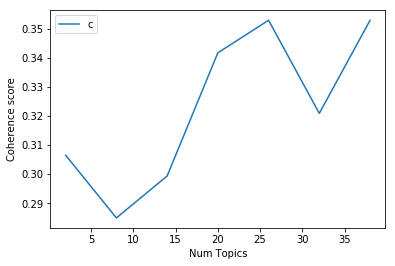

In [21]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=data_clean, start=2, limit=40, step=6)
# Show graph
import matplotlib.pyplot as plt
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

#### Note: 
Topic coherence looks at a set of words in generated topics and rates the interpretability of the topics. 
Hence the Higher the Corherence Score, the better. We can select 25 topics for our model inorder to achieve this maximum score

#### Identify the Unique Acts
This will give us a rough idea of the types of topics we have in our dataset

In [23]:
# The last column 'xrefxternal' tells us the act category
# Let's extract the acts using regex

documents['acts'] = documents['content'].str.extract(r'\A([A-Z\s]+ACT\b)')
act_types = documents.acts.unique()
list(act_types)

['PUBLIC SERVICE SUPERANNUATION ACT FINANCIAL ADMINISTRATION ACT',
 'CANADIAN ENVIRONMENTAL PROTECTION ACT',
 'PUBLIC SERVICE LABOUR RELATIONS ACT',
 'NATIONAL DEFENCE ACT',
 'EXPROPRIATION ACT DRY DOCKS SUBSIDIES ACT NORTHWEST TERRITORIES WATERS ACT DOMINION WATER POWER ACT',
 'CANADA DEPOSIT INSURANCE CORPORATION ACT',
 'DNA IDENTIFICATION ACT',
 'NUCLEAR SAFETY AND CONTROL ACT',
 nan,
 'CONTROLLED DRUGS AND SUBSTANCES ACT',
 'AGRICULTURAL PRODUCTS MARKETING ACT',
 'FOREIGN MISSIONS AND INTERNATIONAL ORGANIZATIONS ACT',
 'HEALTH OF ANIMALS ACT',
 'EXCISE TAX ACT',
 'TOBACCO ACT',
 'CRIMINAL RECORDS ACT',
 'CANADA AGRICULTURAL PRODUCTS ACT',
 'COMPETITION ACT',
 'CANADA NATIONAL PARKS ACT',
 'FINANCIAL ADMINISTRATION ACT',
 'BANK ACT',
 'CANADA SHIPPING ACT',
 'INTERPRETATION ACT',
 'RADIOCOMMUNICATION ACT',
 'NUNAVUT ACT',
 'ROYAL CANADIAN MOUNTED POLICE ACT',
 'TERRITORIAL LANDS ACT',
 'JUDGES ACT',
 'COPYRIGHT ACT',
 'AERONAUTICS ACT',
 'INSURANCE COMPANIES ACT',
 'TRUST AND LOAN C

In [24]:
print("there are a total of", len(act_types), "acts")

there are a total of 237 acts


In [25]:
# What is the frequency of documents under each act type
# The topics we produce using the LDA should reflect some of these popular acts

documents['acts'].value_counts()


AERONAUTICS ACT                                                       122
FINANCIAL ADMINISTRATION ACT                                           81
AGRICULTURAL PRODUCTS MARKETING ACT                                    71
BANK ACT                                                               69
FOREIGN MISSIONS AND INTERNATIONAL ORGANIZATIONS ACT                   49
INSURANCE COMPANIES ACT                                                45
PUBLIC SERVICE EMPLOYMENT ACT                                          41
APPROPRIATION ACT                                                      39
CANADA CONSUMER PRODUCT SAFETY ACT                                     36
COOPERATIVE CREDIT ASSOCIATIONS ACT                                    36
EXPORT AND IMPORT PERMITS ACT                                          36
TRUST AND LOAN COMPANIES ACT                                           35
CUSTOMS ACT                                                            33
CANADIAN ENVIRONMENTAL PROTECTION ACT 

### 2.2) Create the model

In [29]:
# Now we are ready to build the LDA Model
print("Please Wait...")
number_of_topics = 25 # based on the freq of act occurences

lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus, 
                                            id2word = dictionary,
                                            num_topics = number_of_topics, 
                                            random_state = 150,
                                            update_every = 1,
                                            chunksize = 75,
                                            passes = 50,
                                            alpha = 'auto',
                                            per_word_topics=True)
print("Done")

Please Wait...
Done


In [30]:
# We want the same results
from gensim.test.utils import datapath

# Save model to disk.
temp_file = datapath("/Users/eishapatel/Desktop/DS - 8008/DS 8008 - project/model")
lda_model.save(temp_file)

# Load a potentially pretrained model from disk.
lda_model = gensim.models.ldamodel.LdaModel.load(temp_file)

In [92]:
# Print the Keyword in the topics
pprint(lda_model.print_topics(25))

[(0,
  '0.188*"company" + 0.099*"insurance" + 0.057*"loan" + 0.040*"entity" + '
  '0.032*"hold" + 0.031*"bank" + 0.029*"share" + 0.026*"control" + '
  '0.022*"refer" + 0.019*"respect"'),
 (1,
  '0.160*"year" + 0.045*"plan" + 0.042*"refer" + 0.041*"determine" + '
  '0.037*"election" + 0.032*"fiscal" + 0.028*"calendar" + 0.025*"pension" + '
  '0.024*"subparagraph" + 0.021*"case"'),
 (2,
  '0.056*"gas" + 0.040*"oil" + 0.037*"production" + 0.035*"platform" + '
  '0.035*"work" + 0.034*"operation" + 0.024*"classification" + 0.017*"well" + '
  '0.015*"locate" + 0.015*"canada"'),
 (3,
  '0.079*"centre" + 0.059*"facility" + 0.059*"carrier" + 0.056*"transport" + '
  '0.055*"canadian" + 0.050*"transportation" + 0.045*"number" + 0.039*"office" '
  '+ 0.030*"person" + 0.026*"passenger"'),
 (4,
  '0.145*"surface" + 0.119*"point" + 0.082*"limit" + 0.038*"intersection" + '
  '0.032*"zone" + 0.022*"north" + 0.019*"west" + 0.019*"island" + '
  '0.018*"ratio" + 0.017*"associate"'),
 (5,
  '0.052*"bank" +

In [32]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_clean, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -11.116600428011944

Coherence Score:  0.5669770924492247


# 3) Visualize the Topics (pyLDAvis)

In [34]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis=pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, sort_topics=False)

#saving the visualization model into file
pyLDAvis.save_html(vis,'vis25.html')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [35]:
%%HTML
<iframe width="100%" height="500" src="vis25.html"></iframe>
#displaying visualization model into python
#REF: https://shichaoji.com/tag/topic-modeling-python-lda-visualization-gensim-pyldavis-nltk/

# 4) Document Grouping

Each document can be described by a list of topics and values that relates the topics with the document. The list of topics and correlation is unique among documents and can also be considered the signature of the document.
Since one document can be highly correlated to multiple topics, we can create soft clusters of documents using top 'N' topic correlations

In [36]:
from itertools import chain
num_of_docs = 200 # 1753 in total, we will pick the first 200 documents

# to compare the similarity between a document and the detected topics, we need to use vectorized term-freq matrix
# of each document. This is essentially the corpus

correlation_prob = []

for i in range(num_of_docs):
    
    temp1 = list(chain.from_iterable(corpus[:i]))
    temp2 = lda_model[temp1]
    # print(temp2[0])
    
    correlation_prob.append(temp2[0])

# This code will take long to run.

In [114]:
# Create a dataframe to store the correlation probabilities

df = pd.DataFrame(columns=['document', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
                           '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21',
                           '22', '23', '24', '25'])


In [115]:
# append data into dataframe

df['document'] = [i for i in range(len(correlation_prob))]

for doc_num, i in enumerate(correlation_prob):
    
    for j in (i):
        
        if j[0] == 0:
            df.loc[doc_num, ['1']] = j[1]
            
        if j[0] == 1:
            df.loc[doc_num, ['2']] = j[1]
            
        if j[0] == 2:
            df.loc[doc_num, ['3']] = j[1]
            
        if j[0] == 3:
            df.loc[doc_num, ['4']] = j[1]
            
        if j[0] == 4:
            df.loc[doc_num, ['5']] = j[1]
            
        if j[0] == 5:
            df.loc[doc_num, ['6']] = j[1]
            
        if j[0] == 6:
            df.loc[doc_num, ['7']] = j[1]
        
        if j[0] == 7:
            df.loc[doc_num, ['8']] = j[1]
            
        if j[0] == 8:
            df.loc[doc_num, ['9']] = j[1]
            
        if j[0] == 9:
            df.loc[doc_num, ['10']] = j[1]
        
        if j[0] == 10:
            df.loc[doc_num, ['11']] = j[1]
            
        if j[0] == 11:
            df.loc[doc_num, ['12']] = j[1]
            
        if j[0] == 12:
            df.loc[doc_num, ['13']] = j[1]
            
        if j[0] == 13:
            df.loc[doc_num, ['14']] = j[1]
            
        if j[0] == 14:
            df.loc[doc_num, ['15']] = j[1]
            
        if j[0] == 15:
            df.loc[doc_num, ['16']] = j[1]
            
        if j[0] == 16:
            df.loc[doc_num, ['17']] = j[1]
            
        if j[0] == 17:
            df.loc[doc_num, ['18']] = j[1]
            
        if j[0] == 18:
            df.loc[doc_num, ['19']] = j[1]
            
        if j[0] == 19:
            df.loc[doc_num, ['20']] = j[1]

        if j[0] == 20:
            df.loc[doc_num, ['21']] = j[1]
            
        if j[0] == 21:
            df.loc[doc_num, ['22']] = j[1]
            
        if j[0] == 22:
            df.loc[doc_num, ['23']] = j[1]

        if j[0] == 23:
            df.loc[doc_num, ['24']] = j[1]

        if j[0] == 24:
            df.loc[doc_num, ['25']] = j[1]
            
            

#### Create a table of correlations between document and topics

In [116]:
# fill the remaining dataframe 'Nan's' with zeros
df = df.fillna(0)
df

,document,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0,0.025295,0.025046,0.044185,0.035569,0.039053,0.048586,0.031636,0.040699,0.030923,...,0.014431,0.033025,0.039391,0.015494,0.020974,0.039515,0.028574,0.017298,0.073204,0.053512
1,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.020785,0.000000,0.000000,0.000000,...,0.000000,0.021657,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.059317,0.000000
2,2,0.000000,0.000000,0.025649,0.034537,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.018436,0.000000,0.000000,0.000000,0.247659,0.035121,0.000000,0.077792,0.017724
3,3,0.000000,0.026790,0.021028,0.030215,0.000000,0.010864,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.213435,0.034349,0.000000,0.073954,0.000000
4,4,0.000000,0.000000,0.017778,0.019373,0.000000,0.014351,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.151343,0.022205,0.000000,0.069858,0.029046
5,5,0.000000,0.000000,0.019904,0.014531,0.000000,0.011466,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.127352,0.056018,0.000000,0.060235,0.106226
6,6,0.000000,0.000000,0.015724,0.011519,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.022892,0.000000,0.000000,0.000000,0.105366,0.046090,0.000000,0.054472,0.101492
7,7,0.000000,0.000000,0.000000,0.000000,0.000000,0.071735,0.000000,0.000000,0.000000,...,0.011065,0.030986,0.000000,0.000000,0.000000,0.087438,0.037676,0.000000,0.075711,0.086424
8,8,0.000000,0.000000,0.000000,0.000000,0.000000,0.078578,0.000000,0.000000,0.000000,...,0.000000,0.028246,0.000000,0.000000,0.000000,0.107076,0.036113,0.000000,0.085233,0.080912
9,9,0.000000,0.000000,0.016603,0.088736,0.000000,0.036175,0.000000,0.000000,0.010804,...,0.000000,0.021029,0.040394,0.000000,0.000000,0.115041,0.059859,0.000000,0.075256,0.035235


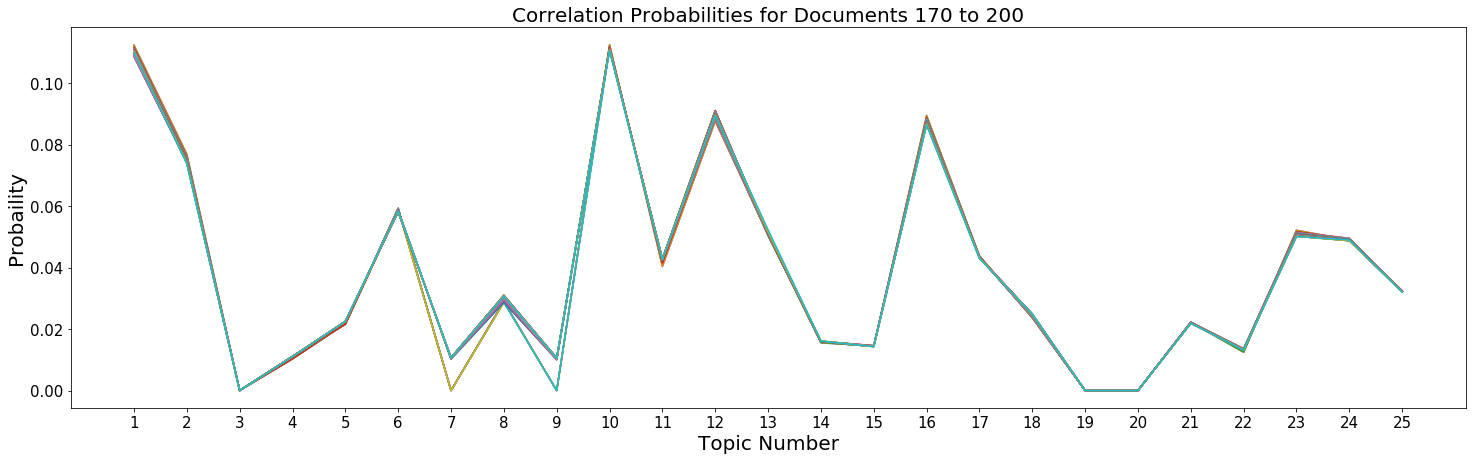

In [124]:
# Example 1
# Plot a figure to show the correlation probabilities of random docs
# Based on the chart above I noticed that documents 170-200 have very similar correalation values
# After plotting their correlation values, I noted that they almost overlap

plt.figure(figsize=[25,7])

for i in range(169,199):

    plt.plot(df.iloc[i][1:26])

plt.title("Correlation Probabilities for Documents 170 to 200", fontsize = 20)
plt.ylabel("Probaility", fontsize = 20)
plt.xlabel("Topic Number", fontsize = 20)
plt.tick_params(axis = 'both', which = 'major', labelsize = 15)
plt.show()

In [103]:
# print the acts that occur in documents 170 to 200
documents.iloc[169:199]['acts'].unique()

array(['EMPLOYMENT EQUITY ACT',
       'INTERNATIONAL BOUNDARY WATERS TREATY ACT', 'AERONAUTICS ACT', nan,
       'INDIAN ACT', 'EXPORT AND IMPORT OF ROUGH DIAMONDS ACT',
       'INSURANCE COMPANIES ACT', 'TRUST AND LOAN COMPANIES ACT',
       'EXCISE ACT', 'SPECIES AT RISK ACT',
       'AGRICULTURAL PRODUCTS MARKETING ACT', 'BANK ACT',
       'COOPERATIVE CREDIT ASSOCIATIONS ACT',
       'FARM PRODUCTS AGENCIES ACT',
       'CANADIAN ENVIRONMENTAL PROTECTION ACT'], dtype=object)

In [125]:
# View the content of random documents between 190-200 to see similarities to topics

print(data_clean[197])

['farm_product', 'agency', 'chicken_farmer', 'canada', 'delegation', 'authority', 'governor', 'council', 'chicken_farmer', 'canada', 'proclamation', 'establish', 'chicken_farmer', 'canada', 'pursuant', 'farm_product', 'agency', 'sor', 'sor', 'par', 'chicken_farmer', 'canada', 'empower', 'implement', 'marketing', 'plan', 'pursuant', 'proclamation', 'chicken_farmer', 'canada', 'pursuant', 'farm_product', 'agency', 'chicken_farmer', 'canada', 'proclamation', 'annex', 'chicken_farmer', 'canada', 'delegation', 'authority', 'par', 'sor', 'excellency', 'governor', 'general', 'council', 'recommendation', 'minister', 'agriculture', 'agri_food', 'pursuant', 'farm_product', 'agency', 'approve', 'annex', 'chicken_farmer', 'canada', 'delegation', 'authority', 'chicken_farmer', 'canada', 'march', 'interpretation', 'expression', 'cfc', 'chicken', 'federal', 'market', 'development', 'quota', 'federal', 'quota', 'marketing', 'producer', 'provincial', 'commodity', 'board', 'provincial', 'market', 'devel

In [126]:
print(data_clean[174])

['custom', 'tariff', 'cifta', 'remission', 'excellency', 'governor', 'general', 'council', 'recommendation', 'minister', 'finance', 'pursuant', 'custom', 'tariff', 'annex', 'cifta', 'remission', 'interpretation', 'good', 'good', 'eligible', 'canada', 'israel', 'agreement', 'tariff', 'rate', 'duty', 'december', 'import', 'eligible', 'rate', 'duty', 'import', 'january', 'remission', 'subject', 'remission', 'grant', 'custom', 'duty', 'pay', 'payable', 'custom', 'tariff', 'good', 'import', 'period', 'commence', 'january', 'december', 'amount', 'equal', 'difference', 'custom', 'duty', 'pay', 'payable', 'favoured_nation', 'tariff', 'rate', 'general', 'preferential_tariff', 'rate', 'duty', 'good', 'case', 'custom', 'tariff', 'read', 'january', 'custom', 'duty', 'payable', 'canada', 'israel', 'agreement', 'tariff', 'rate', 'duty', 'good', 'good', 'qualified', 'rate', 'duty', 'custom', 'tariff', 'read', 'january', 'condition', 'remission', 'grant', 'condition', 'claim', 'remission', 'minister',

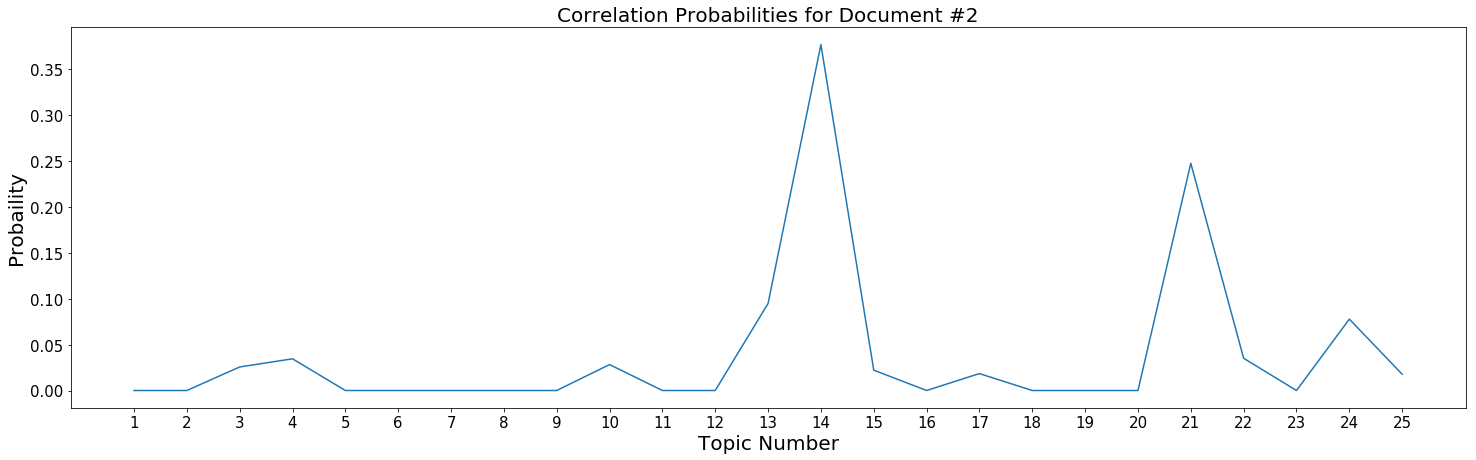

In [127]:
# Example 2
# Plot a figure to show the correlation probabilities of random doc

plt.figure(figsize=[25,7])

plt.plot(df.iloc[2][1:26])

plt.title("Correlation Probabilities for Document #2", fontsize = 20)
plt.ylabel("Probaility", fontsize = 20)
plt.xlabel("Topic Number", fontsize = 20)
plt.tick_params(axis = 'both', which = 'major', labelsize = 15)
plt.show()

In [105]:
documents.iloc[2]['acts']

'PUBLIC SERVICE LABOUR RELATIONS ACT'

In [106]:
print(data_clean[2])

['public', 'service', 'labour_relation', 'designate', 'staff', 'public', 'fund', 'canadian', 'force', 'separate', 'employer', 'purpose', 'excellency', 'governor', 'general', 'council', 'recommendation', 'minister', 'national_defence', 'pursuant', 'public', 'service', 'staff_relation', 'designate', 'staff', 'public', 'fund', 'canadian', 'force', 'separate', 'employer', 'purpose', 'public', 'service', 'staff_relation', 'provision', 'reference', 'context_requir', 'reference', 'public', 'service', 'labour_relation', 'provision', 'define', 'statutory_instrument', 'parliament', 'provision', 'refer', 'read', 'reference', 'federal', 'public', 'sector_labour_relation']
